In [11]:

import pandas as pd
import numpy as np

import time
import pickle

from sklearn.impute import SimpleImputer
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold
from sklearn.preprocessing import scale
from sklearn.metrics import accuracy_score
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.datasets import make_blobs, make_moons, load_iris, load_digits
from sklearn.cluster import *
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import homogeneity_score, homogeneity_completeness_v_measure
from sklearn.preprocessing import scale
from collections import Counter

import hdbscan
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)
plt.style.use('seaborn')

In [2]:
#load in the data from the pickle objects
all_schools = pd.read_pickle("allschools_df.pkl")
public_schools = pd.read_pickle("public_df.pkl")
for_profit = pd.read_pickle("forprofit_df.pkl")
non_profit = pd.read_pickle("nonprofit_df.pkl")

allschoolsPCA = pd.read_pickle("allschoolsPCA.pkl")
publicPCA = pd.read_pickle("publicschoolPCA.pkl")
nonprofitPCA = pd.read_pickle("nonprofitPCA.pkl")
forprofitPCA = pd.read_pickle("forprofitPCA.pkl")

In [ ]:
all_schools.index.values

In [ ]:
nonprofit_scale = scale(non_profit, axis=1)

ks = range(1,50)
scores = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit_predict(nonprofit_scale)
    scores.append(-model.score(nonprofit_scale))

plt.plot(ks, scores)
plt.ylabel('total intra-cluster distance')
plt.xlabel('k')
plt.show()

In [ ]:
#adapted from https://stackoverflow.com/questions/25633383/how-can-gridsearchcv-be-used-for-clustering-meanshift-or-dbscan

def dbscan_grid_search(X_data, lst, clst_count, eps_space = 0.5,
                       min_samples_space = 5, min_clust = 0, max_clust = 10):

    """
Performs a hyperparameter grid search for DBSCAN.

Parameters:
    * X_data            = data used to fit the DBSCAN instance
    * lst               = a list to store the results of the grid search
    * clst_count        = a list to store the number of non-whitespace clusters
    * eps_space         = the range values for the eps parameter
    * min_samples_space = the range values for the min_samples parameter
    * min_clust         = the minimum number of clusters required after each search iteration in order for a result to be appended to the lst
    * max_clust         = the maximum number of clusters required after each search iteration in order for a result to be appended to the lst

"""
    # Starting a tally of total iterations
    n_iterations = 0

    # Looping over each combination of hyperparameters
    for eps_val in eps_space:
        for samples_val in min_samples_space:

            dbscan_grid = DBSCAN(eps = eps_val,
                                 min_samples = samples_val)

            # fit_transform
            clusters = dbscan_grid.fit_predict(X = X_data)

            labels = dbscan_grid.labels_

            n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise_ = list(labels).count(-1)
            

            # Counting the amount of data in each cluster
            cluster_count = Counter(clusters)

            # Saving the number of clusters
            n_clusters = sum(abs(pd.np.unique(clusters))) - 1

            # Increasing the iteration tally with each run of the loop
            n_iterations += 1

            # Appending the lst each time n_clusters criteria is reached
            if n_clusters >= min_clust and n_clusters <= max_clust:
                
                dbscan_clusters.append(["Epsilon: %d" % eps_val,
                                        "Minimum points: %d" % samples_val,
                                        "Number of clusters: %d" % n_clusters,
                                       "Estimated number of noise points: %d" % n_noise_,
                                       "Homogeneity: %0.3f" % metrics.homogeneity_score(X_data[:, 1], labels),
                                       "Completeness: %0.3f" % metrics.completeness_score(X_data[:, 1], labels),
                                       "V-measure: %0.3f" % metrics.v_measure_score(X_data[:, 1], labels),
                                       "Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(X_data[:, 1], labels),
                                       "Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_data[:, 0].reshape(-1,1), labels)])

                clst_count.append(cluster_count)

    # Printing grid search summary information
    print(f"""Search Complete. \nYour list is now of length {len(lst)}. """)
    print(f"""Hyperparameter combinations checked: {n_iterations}. \n""")


### Clustering w/ DBSCAN for all school data

In [ ]:
%%time
# Scaling  data
dbscan_scaler = StandardScaler()

dbscan_scaler.fit(all_schools)

dbscan_X_scaled = dbscan_scaler.transform(all_schools)

# Setting empty lists in global environment
dbscan_clusters = []
cluster_count   = []


# Inputting function parameters
dbscan_grid_search(X_data = dbscan_X_scaled,
                   lst = dbscan_clusters,
                   clst_count = cluster_count,
                   eps_space = pd.np.arange(1, 10, 0.5),
                   min_samples_space = pd.np.arange(20, 150, 25),
                   min_clust = 2,
                   max_clust = 20)

In [ ]:
dbscan_clusters

In [ ]:
#put the list of results into pickle objects
with open('all_cluster_list.pkl', 'wb') as f:
    pickle.dump(dbscan_clusters, f)

In [3]:
#read the pickle back in
with open('all_cluster_list.pkl', 'rb') as f:
    all_cluster_result = pickle.load(f)

In [ ]:
final_dbscan_model_all = DBSCAN(eps=7, min_samples=20)
final_dbscan_model_all.fit(dbscan_X_scaled)
y_pred = final_dbscan_model_all.fit_predict(dbscan_X_scaled)

dblabels = final_dbscan_model_all.labels_



# dbclusterlist = list(zip(dblabels, list(csc_df.iloc[:,0])))
# print(dbclusterlist)

In [ ]:

plt.figure(figsize=(10, 10))
plt.scatter(dbscan_X_scaled[:,-5], dbscan_X_scaled[:, -8], c=dbscan_X_scaled[:, 3],  marker="o", 
            alpha=0.6, cmap='Reds')

# plt.xlim(df_PCA[:,0].min()-1,df_PCA[:,0].max()+1)
# plt.ylim(df_PCA[:,1].min()-1,df_PCA[:,1].max()+1)

# for i,name in enumerate(states):
#     plt.annotate(name, (df_PCA[i,0], df_PCA[i,1]), fontsize=9, alpha=0.5)
plt.show()

### HDBSCAN with Principal Components of All Schools

In [ ]:
%%time

# Setting empty lists in global environment
dbscan_clusters_all = []
cluster_count_all   = []


# Inputting function parameters
dbscan_grid_search(X_data = allschoolsPCA,
                   lst = dbscan_clusters_all,
                   clst_count = cluster_count_all,
                   eps_space = pd.np.arange(1, 20, 2),
                   min_samples_space = pd.np.arange(10, 100, 5),
                   min_clust = 2,
                   max_clust = 20)

dbscan_clusters_all

In [ ]:
%%time
clusterer = hdbscan.HDBSCAN(min_cluster_size=10)
cluster_labels = clusterer.fit_predict(allschoolsPCA)

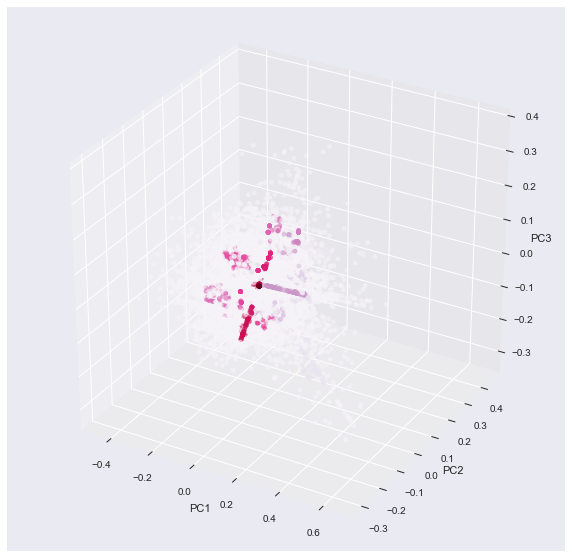

In [17]:

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

x = allschoolsPCA.PC1
y = allschoolsPCA.PC2
z = allschoolsPCA.PC3

ax.scatter(x, y, z, c= cluster_labels , marker='o', cmap='PuRd', alpha=0.6)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

plt.show()

CPU times: user 1.05 s, sys: 4.1 ms, total: 1.05 s
Wall time: 331 ms


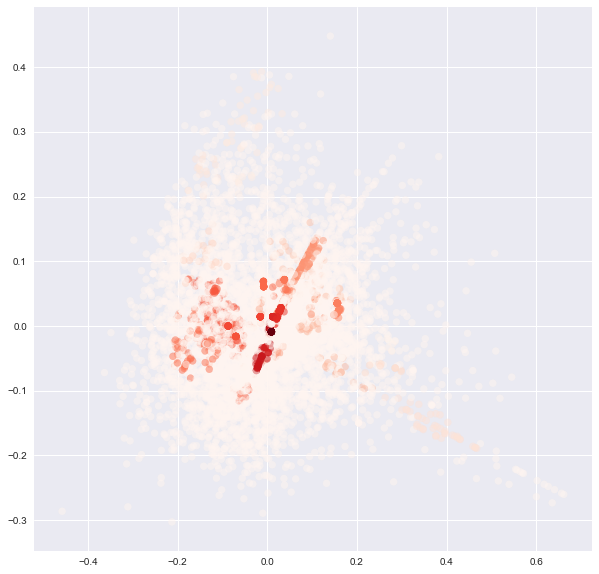

In [10]:
plt.figure(figsize=(10, 10))
plt.scatter(allschoolsPCA.PC1, allschoolsPCA.PC2, c=cluster_labels,  marker="o", cmap='Reds', alpha=0.5)

# plt.xlim(allschoolsPCA[:,0].min()-1, allschoolsPCA[:,0].max()+1)
# plt.ylim(allschoolsPCA[:,1].min()-1, allschoolsPCA[:,1].max()+1)
plt.show

In [6]:
clusterer.labels_.max()

137

In [ ]:
allschoolsPCA.shape

In [ ]:
allschoolsPCA.head()